In [1]:
# allocate memory
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "32g") \
    .appName('my-cool-app') \
    .getOrCreate()

In [2]:
import os    
import findspark
import re
from functools import reduce
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

os.environ['SPARK_HOME'] = 'C:\\Users\\msi\\Desktop\\spark\\spark-3.0.1-bin-hadoop3.2'
findspark.init()
exec(open(os.path.join(os.environ["SPARK_HOME"], 'python/pyspark/shell.py')).read())

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 3.0.1
      /_/

Using Python version 3.8.3 (default, Jul  2 2020 17:30:36)
SparkSession available as 'spark'.


In [3]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, StandardScaler, VectorAssembler, VectorSlicer, PCA
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, LinearSVC, NaiveBayes, DecisionTreeClassifier
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col, lit, udf, mean as _mean, isnan, sum as _sum, log as _log, when
from pyspark.ml.clustering import KMeans
from pyspark.sql.types import FloatType, ArrayType, IntegerType
from pyspark.sql import DataFrame
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import Evaluator

In [4]:
train_df= spark.read.csv('C:\\Users\\msi\\Onedrive\\MOA\\train_features.csv', header=True, inferSchema=True)
target_df = spark.read.csv('C:\\Users\\msi\\Onedrive\\MOA\\train_targets_scored.csv', header=True, inferSchema=True)
test_df = spark.read.csv('C:\\Users\\msi\\Onedrive\\MOA\\test_features.csv', header=True, inferSchema=True)

In [5]:
train_df.cache()
target_df.cache()
test_df.cache()

DataFrame[sig_id: string, cp_type: string, cp_time: int, cp_dose: string, g-0: double, g-1: double, g-2: double, g-3: double, g-4: double, g-5: double, g-6: double, g-7: double, g-8: double, g-9: double, g-10: double, g-11: double, g-12: double, g-13: double, g-14: double, g-15: double, g-16: double, g-17: double, g-18: double, g-19: double, g-20: double, g-21: double, g-22: double, g-23: double, g-24: double, g-25: double, g-26: double, g-27: double, g-28: double, g-29: double, g-30: double, g-31: double, g-32: double, g-33: double, g-34: double, g-35: double, g-36: double, g-37: double, g-38: double, g-39: double, g-40: double, g-41: double, g-42: double, g-43: double, g-44: double, g-45: double, g-46: double, g-47: double, g-48: double, g-49: double, g-50: double, g-51: double, g-52: double, g-53: double, g-54: double, g-55: double, g-56: double, g-57: double, g-58: double, g-59: double, g-60: double, g-61: double, g-62: double, g-63: double, g-64: double, g-65: double, g-66: double

In [6]:
def encode_cat_features(df, cat_features):

  indexed_cols = [''.join([col_name, '_indexed']) for col_name in cat_features]
  encoded_cols = [''.join([col_name, '_encoded']) for col_name in cat_features]
  string_indexers = [StringIndexer(inputCol=cat_features[i], outputCol=indexed_cols[i]) for i in range(len(cat_features))]
    
  encoder = OneHotEncoder(inputCols=indexed_cols, outputCols=encoded_cols)
  
  pipline = Pipeline(stages=string_indexers + [encoder])
  
  encoded_df = pipline.fit(df).transform(df)
  encoded_df = encoded_df.drop(*indexed_cols + cat_features)

  return encoded_df

def normalize_features(df, cols, normalizer, output_cols, if_drop=True):
  """
  """
  normalizer_lst = []
  vectorized_cols = []
  vector_assembers = []
  
  if isinstance(cols, list):
    cols = {'cols': cols}
  
  if isinstance(output_cols, str):
    output_cols = {'cols': output_cols}
  
  for k, v in cols.items():
    
    temp_normalizer = normalizer.copy()
    vectorized_col = ''.join([output_cols[k], '_v'])
    vector_assember = VectorAssembler(inputCols=v, outputCol=vectorized_col)
    
    temp_normalizer.setInputCol(vectorized_col)
    temp_normalizer.setOutputCol(output_cols[k])
    
    normalizer_lst.append(temp_normalizer)
    vectorized_cols.append(vectorized_col)
    vector_assembers.append(vector_assember)
  
  pipline = Pipeline(stages=vector_assembers + normalizer_lst)
  normalized_df = pipline.fit(df).transform(df).drop(*vectorized_cols)
  
  if if_drop:
    
    for k, v in cols.items():
      
      normalized_df = normalized_df.drop(v)
  
  return normalized_df

def add_pca_features(df, g_cols, c_cols, k=40):
  
  ## normalize g-col and c-col
  std_scaler = StandardScaler(withMean=True)
  
  input_cols = {
    'g_cols': g_cols, 
    'c_cols': c_cols}
  
  output_cols = {
    'g_cols': 'g_normalized', 
    'c_cols': 'c_normalized'}
  
  normalized_df = normalize_features(df, input_cols, std_scaler, output_cols, if_drop=False)
  
  ## perform PCA on g-cols and c-cols
  g_col_pca = PCA(k=k, inputCol='g_normalized', outputCol='g_col_pca')
  c_col_pca = PCA(k=k, inputCol='c_normalized', outputCol='c_col_pca')
  
  pipeline = Pipeline(stages=[g_col_pca, c_col_pca])
  pca_df = pipeline.fit(normalized_df).transform(normalized_df)
  
  return pca_df
  
def add_stats_features(df, g_cols, c_cols):
  
  @udf('double')
  def cols_sum(*lst):

    return sum(lst)

  @udf('double')
  def cols_mean(*lst):

    n = len(lst)
    s = sum(lst)

    return s / n

  @udf('double')
  def cols_var(*lst):

    n = len(lst)
    s = sum(lst) / n
    total = 0

    for x in lst:

      total += (x - s)**2 

    return total / n
  
  @udf('double')
  def cols_min(*lst):
    
    return min(lst)
  
  @udf('double')
  def cols_max(*lst):
    
    return max(lst)
  
  stats_dict = {
    'min_stats': cols_min,
    'max_stats': cols_max,
    'var_stats': cols_var,
    'mean_stats': cols_mean,
    'sum_stats': cols_sum
  }
  
  for name, func in stats_dict.items():
    
    df = df.withColumn(''.join(['g_cols_', name]), func(*[col(g_col) for g_col in g_cols]))
    df = df.withColumn(''.join(['c_cols_', name]), func(*[col(c_col) for c_col in c_cols]))
  
  return df

def add_kmeans_features(df, g_cols, c_cols, k=2, num_iter=10):
  
  kmeans_g = KMeans(k=k, featuresCol=g_cols, predictionCol='g_col_k_mean', seed=16)
  kmeans_c = KMeans(k=k, featuresCol=c_cols, predictionCol='c_col_k_mean', seed=16)
  
  kmeans_df = kmeans_g.fit(df).transform(df)
  kmeans_df = kmeans_c.fit(kmeans_df).transform(kmeans_df)
  
  return kmeans_df

def feature_engineering(df, num_cluster=2, num_comp=40, num_iter=10):
  
  ## get g-col and c-col
  g_cols = list(filter(lambda v: re.match('g-.+', v), df.columns))
  c_cols = list(filter(lambda v: re.match('c-.+', v), df.columns))
  
  ## PCA
  pca_df = add_pca_features(df, g_cols, c_cols, num_comp)

  ## stats features on g and c cols
  stats_df = add_stats_features(pca_df, g_cols, c_cols)
  
  ## add k-means features
  kmeans_df = add_kmeans_features(stats_df, g_cols='g_normalized', c_cols='c_normalized', k=num_cluster, num_iter=num_iter)
  
  return kmeans_df

def get_correlation(df, threshold=0.95, feature_col='all_features', plot=False):
    
    from pyspark.ml.stat import Correlation
    from pyspark.sql.types import FloatType, ArrayType, IntegerType
    import numpy as np
    
    r1 = Correlation.corr(df, feature_col)
    r1 = r1.select(f'pearson({feature_col})').collect()[0][f'pearson({feature_col})'].toArray().tolist()
    
    if plot:
        plt.figure(figsize=(20, 10))
        cor_plt_array = np.array(r1)
        sns.heatmap(cor_plt_array)
        
    r1 = spark.createDataFrame(r1)
    gv = sc.broadcast(threshold)
    va = VectorAssembler(inputCols=r1.columns, outputCol='features')
    r1 = va.transform(r1)
    
    def find_element(row, gv):
    
        lst = []

        for i in range(len(row)):

            if (row[i] >= gv.value) | (row[i] <= -gv.value):
                lst.append(i)
        
        if len(lst) == 1:
            lst = []
            
        return lst

    m = udf(lambda x: find_element(x, gv), ArrayType(IntegerType()))
    
    return r1.withColumn('new_col', m('features')).select('new_col')
    

In [7]:
## add indicator column to both train and test so we can combine them later
train_df = train_df.withColumn('is_test', lit(0))
test_df = test_df.withColumn('is_test', lit(1))

## Combine train and test df
full_df = train_df.union(test_df)

In [8]:
## encode features
target_cols = ['cp_type', 'cp_dose']
encoded_df = encode_cat_features(full_df, target_cols)

+------------+
|     new_col|
+------------+
|    [46, 48]|
|          []|
|[20, 47, 49]|
|     [0, 44]|
+------------+



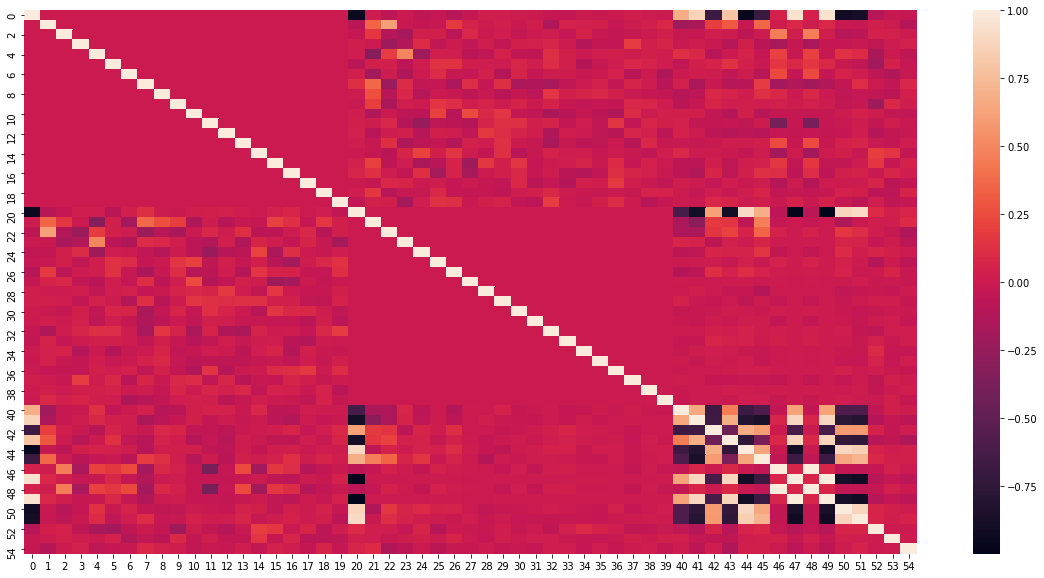

In [9]:

## feature engineering
fe_df = feature_engineering(encoded_df, num_comp=20, num_iter=5)

## select all the feature columns

pca_cols = list(filter(lambda v: re.match('.+_pca', v), fe_df.columns))
stats_cols = list(filter(lambda v: re.match('.+_stats', v), fe_df.columns))
k_means_cols = list(filter(lambda v: re.match('.+_k_mean', v), fe_df.columns))
cat_cols = list(filter(lambda v: re.match('.+_encoded', v), fe_df.columns)) + ['cp_time']
all_cols = pca_cols + stats_cols + k_means_cols + cat_cols
## stack them to a single feature vector
vector_assember_train = VectorAssembler(inputCols=all_cols, outputCol='all_features')
fe_df = vector_assember_train.transform(fe_df)

## Check their correlation
corr_df = get_correlation(fe_df, 0.96, plot=True)
corr_df.dropDuplicates().show()

In [10]:
## 40 PCA columns
## looking for position 3, 6, 7, 8
(stats_cols + k_means_cols + cat_cols)[3]

'c_cols_max_stats'

In [11]:
(stats_cols + k_means_cols + cat_cols)[6]

'g_cols_mean_stats'

In [12]:
(stats_cols + k_means_cols + cat_cols)[7]

'c_cols_mean_stats'

In [13]:
(stats_cols + k_means_cols + cat_cols)[8]

'g_cols_sum_stats'

In [14]:
high_corr_features = ['c_cols_max_stats', 'g_cols_mean_stats', 'c_cols_mean_stats', 'g_cols_sum_stats']

In [15]:
## stack them to a single feature vector again, and remove those features with high correlation
vector_assember_train = VectorAssembler(inputCols=[col for col in all_cols if col not in high_corr_features], outputCol='all_features')
fe_df = vector_assember_train.transform(fe_df.drop('all_features'))

In [16]:
## normalize all the features
normalizer = StandardScaler(withMean=True)
cols = ['all_features']
output_cols = 'features'
fe_df = normalize_features(fe_df, cols, normalizer, output_cols, if_drop=False)

## split train, test df
fe_train = fe_df.filter(fe_df['is_test'] == 0)
final_test = fe_df.filter(fe_df['is_test'] == 1).select(['sig_id', 'features'])

## join training target with training features
labels = target_df.drop('sig_id').columns
final_train = fe_train.join(target_df, ['sig_id']).select(*(['sig_id','features'] + labels))


In [17]:
## train test split
(cv_train, test) = final_train.randomSplit([0.8, 0.2], 16)
(train, validation) = cv_train.randomSplit([0.8, 0.2], 16)

train.cache()
cv_train.cache()
validation.cache()
test.cache()
train_df.unpersist()
test_df.unpersist()
target_df.unpersist()
fe_train.unpersist()
fe_df.unpersist()
final_train.unpersist()
encoded_df.unpersist()
corr_df.unpersist()

DataFrame[new_col: array<int>]

In [27]:
from tqdm import tqdm
# Multilabel Classifier
class MultiLabelClassifier:
    
    def __init__(self, clf, labels, feature_col,  
                 hyperparameters=[], 
                 predict_col=['probability','prediction'],
                 method=lambda prob_col, pred_col: float(pred_col if len(prob_col) == 1 else prob_col[1])):
        '''
        Initialize a multilabelclassifier
        clf: the model to use
        labels: a list of labels to predict
        feature_col: the feature column
        predict_col: the prediction column where the prediction is located
        hyperparameters: all optional hyperparameters that can tune
        method: a method of how to get the final prediction for one class
        '''
        self.clf = clf
        self.labels = labels
        self.feature_col = feature_col
        self.predict_col = predict_col
        self.hyperparameters = hyperparameters
        self.method = method
        self._trained_clfs = []

    def fit(self, train):
        
        train.cache()
        
        for label, hyperparameters in tqdm(zip(self.labels, self.hyperparameters)):
            ## add weight col
            temp_train = train.withColumn('weight', when(col(label) == 1, 2).otherwise(1))
            temp_clf = self.clf(labelCol=label, featuresCol=self.feature_col, weightCol='weight', **hyperparameters).fit(temp_train)
            self._trained_clfs.append(temp_clf)
            
            temp_train.unpersist()
            
        return self

    def transform(self, x_test):
        # convert method to udf
        get_predict = udf(self.method,FloatType())
        #target assembler
        va = VectorAssembler(inputCols=self.labels, outputCol='targets')
        ## transform this vector self.output_col to an array
        select_cols = [self.feature_col, 'targets', 'sig_id']
        res = va.transform(x_test).select(*select_cols)
        for i, clf in tqdm(enumerate(self._trained_clfs)):
            res = clf.transform(res)
            new_col = self.labels[i]
            res = res.withColumn(new_col, get_predict(*self.predict_col))
            select_cols.append(new_col)
            res = res.select(*select_cols)
        self.res = res
        return res.select(*select_cols[2:])
    
    def score(self):
        #target assembler 
        va = VectorAssembler(inputCols=self.labels, outputCol='predicts')
        ## transform this vector self.output_col to an array
        df = va.transform(self.res).select('targets', 'predicts')
        df = df.withColumn('targets', vector_to_array('targets'))
        df = df.withColumn('predicts', vector_to_array('predicts'))
        import math
        @udf('double')
        def log_loss(y, y_hat):
            r = 0
            cut = 1e-15
            for t, p in zip(y, y_hat):
                p = max(min(p, 1-cut),cut)
                r += t * math.log(p) + (1 - t) * math.log(1 - p)
            return r/len(y)
        df = df.select(log_loss('targets','predicts').alias('log_loss'))
        return df.select((-_mean(col('log_loss'))).alias('score'))
    
    def param_search_cv(self, train, grid_map, fold_num):
        """
        Perform param search on each binary classifier
        
        train: the traning set for cross validation
        grid_map: the param grid map contains params for tunning
        fold_num: number of folds for k fold cross validation
        return: a list of dict({param: value}), one dict for each binary classifier
        """
                   
        train.cache()
        best_params = []
        
        def _extract_best_params(cv_model):
            """
            extract best params from cross validation output
            
            cv_model: CrossValidationModel
            return: dict({param: value})
            """
            
            best_param_dict = {}
            scores = cv_model.avgMetrics
            best_param = cv_model.getEstimatorParamMaps()[scores.index(min(scores))]

            for k, v in best_param.items():
                best_param_dict[k.name] = v
            
            return best_param_dict
            
        for label in tqdm(self.labels):
            
            ## for each label: init classifier, evaluator, cross validator
            clf = self.clf(labelCol=label, featuresCol=self.feature_col)
            evaluator = MultilabelEvaluator(method=self.method, predictionCol=self.predict_col, labelCol=label)
            cv = CrossValidator(estimator=clf, estimatorParamMaps=grid_map, numFolds=fold_num, evaluator=evaluator, parallelism=4)
            
            ## fit the cross validator and  extract best params for this binary classifier
            cv_model = cv.fit(train)
            best_model = cv_model.bestModel
            best_param = _extract_best_params(cv_model)
            
            ## append best model and append the best params
            self._trained_clfs.append(best_model)
            best_params.append(best_param) 
        
        return best_params
    

class MultilabelEvaluator(Evaluator):
    
    def __init__(self, method, predictionCol=['probability', 'prediction'], labelCol="label"):
        
        self.predictionCol = predictionCol
        self.labelCol = labelCol
        self.method = method
        
    def _evaluate(self, dataset):
        """
        calculate log loss for single binary classifier's prediction
        
        dataset: the dataset contains the output of the binary classifier
        return: the log loss score
        """
        ## log loss for single binary classifier
        get_predict = udf(self.method,FloatType())
        dataset = dataset.withColumn('pred_prob', get_predict(*self.predictionCol))
        cut = 1e-15
        new_dataset = dataset.select((-col(self.labelCol) * _log(col('pred_prob') + cut) - (1.0 - col(self.labelCol)) * _log(1.0 - col('pred_prob') + cut)).alias('log_loss'))        
        score = new_dataset.select(_mean(col('log_loss')).alias('score')).collect()[0]['score']
        return score
        
    def isLargerBetter(self):
        return False
    

In [19]:
def convert_to_array(prob_col, pred_col):
    """
    extract probability of class1 from output probability column prob_col which consists of [prob of class0, prob of class1], if len(prob_col) == 1, 
    then use the pred_col.
    
    prob_col: probability column
    pred_col: prediction column
    return probability of class1
    """
    
    ## solve na problem, if len(prob_col) == 1, we use the prediction col
    converted_prob_col = prob_col.toArray().tolist()

    if len(converted_prob_col) == 1:

        return pred_col

    else:

        return converted_prob_col[1]

In [20]:
# clf = DecisionTreeClassifier
# hyperparameters = {'maxDepth': 2, 'impurity': 'gini'}
# method = convert_to_array
# new_dt = MultiLabelClassifier(clf, labels, 'features', hyperparameters=hyperparameters, method=method)

In [21]:
# new_dt.fit(train).transform(validation)
# new_dt.score().show()

In [24]:
## test
clf = DecisionTreeClassifier
grid_map = ParamGridBuilder().addGrid(clf().maxDepth, [1, 4, 7]).addGrid(clf().impurity, ['gini', 'entropy']).addGrid(clf().maxBins, [8, 32, 64]).addGrid(clf().minInstancesPerNode, [1, 8, 16]).build()
method = convert_to_array
dt = MultiLabelClassifier(clf, labels, 'features', method=method)

In [25]:
best_params = dt.param_search_cv(cv_train, grid_map, 3)

100%|████████████████████████████████████████████████████████████████████████████| 206/206 [16:22:42<00:00, 286.23s/it]


In [26]:
best_params

[{'maxDepth': 1, 'impurity': 'gini', 'maxBins': 8, 'minInstancesPerNode': 1},
 {'maxDepth': 1, 'impurity': 'gini', 'maxBins': 8, 'minInstancesPerNode': 1},
 {'maxDepth': 1, 'impurity': 'gini', 'maxBins': 8, 'minInstancesPerNode': 1},
 {'maxDepth': 1, 'impurity': 'gini', 'maxBins': 8, 'minInstancesPerNode': 1},
 {'maxDepth': 1, 'impurity': 'gini', 'maxBins': 8, 'minInstancesPerNode': 1},
 {'maxDepth': 1, 'impurity': 'gini', 'maxBins': 8, 'minInstancesPerNode': 1},
 {'maxDepth': 1, 'impurity': 'gini', 'maxBins': 8, 'minInstancesPerNode': 1},
 {'maxDepth': 1, 'impurity': 'gini', 'maxBins': 8, 'minInstancesPerNode': 1},
 {'maxDepth': 1, 'impurity': 'gini', 'maxBins': 8, 'minInstancesPerNode': 1},
 {'maxDepth': 1, 'impurity': 'gini', 'maxBins': 8, 'minInstancesPerNode': 1},
 {'maxDepth': 1, 'impurity': 'gini', 'maxBins': 8, 'minInstancesPerNode': 1},
 {'maxDepth': 1, 'impurity': 'gini', 'maxBins': 8, 'minInstancesPerNode': 1},
 {'maxDepth': 1, 'impurity': 'gini', 'maxBins': 8, 'minInstances

In [50]:
clf = DecisionTreeClassifier
method = convert_to_array
new_dt = MultiLabelClassifier(clf, labels, 'features', hyperparameters=[{}]*len(labels), method=method)

In [51]:
best_params

[{'maxDepth': 1, 'impurity': 'gini', 'maxBins': 8, 'minInstancesPerNode': 1},
 {'maxDepth': 1, 'impurity': 'gini', 'maxBins': 8, 'minInstancesPerNode': 1},
 {'maxDepth': 1, 'impurity': 'gini', 'maxBins': 8, 'minInstancesPerNode': 1},
 {'maxDepth': 1, 'impurity': 'gini', 'maxBins': 8, 'minInstancesPerNode': 1},
 {'maxDepth': 1, 'impurity': 'gini', 'maxBins': 8, 'minInstancesPerNode': 1},
 {'maxDepth': 1, 'impurity': 'gini', 'maxBins': 8, 'minInstancesPerNode': 1},
 {'maxDepth': 1, 'impurity': 'gini', 'maxBins': 8, 'minInstancesPerNode': 1},
 {'maxDepth': 1, 'impurity': 'gini', 'maxBins': 8, 'minInstancesPerNode': 1},
 {'maxDepth': 1, 'impurity': 'gini', 'maxBins': 8, 'minInstancesPerNode': 1},
 {'maxDepth': 1, 'impurity': 'gini', 'maxBins': 8, 'minInstancesPerNode': 1},
 {'maxDepth': 1, 'impurity': 'gini', 'maxBins': 8, 'minInstancesPerNode': 1},
 {'maxDepth': 1, 'impurity': 'gini', 'maxBins': 8, 'minInstancesPerNode': 1},
 {'maxDepth': 1, 'impurity': 'gini', 'maxBins': 8, 'minInstances

In [52]:
new_dt.fit(train).transform(validation)

206it [05:44,  1.67s/it]
206it [01:26,  2.39it/s]


DataFrame[sig_id: string, 5-alpha_reductase_inhibitor: float, 11-beta-hsd1_inhibitor: float, acat_inhibitor: float, acetylcholine_receptor_agonist: float, acetylcholine_receptor_antagonist: float, acetylcholinesterase_inhibitor: float, adenosine_receptor_agonist: float, adenosine_receptor_antagonist: float, adenylyl_cyclase_activator: float, adrenergic_receptor_agonist: float, adrenergic_receptor_antagonist: float, akt_inhibitor: float, aldehyde_dehydrogenase_inhibitor: float, alk_inhibitor: float, ampk_activator: float, analgesic: float, androgen_receptor_agonist: float, androgen_receptor_antagonist: float, anesthetic_-_local: float, angiogenesis_inhibitor: float, angiotensin_receptor_antagonist: float, anti-inflammatory: float, antiarrhythmic: float, antibiotic: float, anticonvulsant: float, antifungal: float, antihistamine: float, antimalarial: float, antioxidant: float, antiprotozoal: float, antiviral: float, apoptosis_stimulant: float, aromatase_inhibitor: float, atm_kinase_inhibi

In [45]:
best_dt.score().show()

+------------------+
|             score|
+------------------+
|0.0202603619197878|
+------------------+



In [53]:
baseline_dt.score().show()

+-------------------+
|              score|
+-------------------+
|0.04058623757751332|
+-------------------+



In [ ]:
# def cross_validation(df, estimator, k=2):
    
#     num_per_fold = 100 // k * 0.01
#     num = [num_per_fold] * (k - 1) + [1 - num_per_fold * (k - 1)] 
#     k_fold_df = df.randomSplit(num)
#     acc = []
    
#     def unionAll(*dfs):
#         return reduce(DataFrame.unionAll, dfs)
    
#     for i, fold in enumerate(k_fold_df):
        
#         validation = fold
#         train = unionAll(*[k_fold_df[j] for j in range(len(k_fold_df)) if i != j])
        
#         clf = estimator.fit(train)
#         res = clf.transform(validation)
#         score = clf.score().collect()[0]['score']
        
#         validation.unpersist()
#         train.unpersist()
#         estimator.reset()
        
#         acc.append(score)
        
#     mean_acc =  sum(acc) / k
    
#     print(f'the acc are {acc}, the mean acc is {mean_acc}')
    
#     return mean_acc

# def extract_params(grid_map):
    
#     output_lst = []
    
#     for params in grid_map:
#         temp_dict = {}
        
#         for k, v in params.items():
#             temp_dict[k.name] = v
        
#         output_lst.append(temp_dict)
        
#     return output_lst

# def grid_search(train, estimator, grid_map, k=2):
    
#     params = extract_params(grid_map)
#     results = {}
    
#     for param in params:
#         print(f'evaluating param {param}')
        
#         estimator.hyperparameters = param
#         result = cross_validation(train, estimator, k)
        
#         if result in results.keys():
#             results[result].append(param)
            
#         else:
#             results[result] = [param]

#     return param

